# Rainiers Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 17 # rainiers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              4507 non-null   int64  
 1   dimCustomerMasterId       4507 non-null   int64  
 2   customerNumber            4507 non-null   object 
 3   year                      4507 non-null   object 
 4   productGrouping           4507 non-null   object 
 5   totalSpent                4507 non-null   float64
 6   recentDate                4507 non-null   object 
 7   attendancePercent         4507 non-null   float64
 8   renewedBeforeDays         4507 non-null   int64  
 9   isBuyer                   4507 non-null   object 
 10  source_tenure             4507 non-null   int64  
 11  tenure                    4507 non-null   int64  
 12  distToVenue               4507 non-null   float64
 13  totalGames                4507 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          4507 non-null   int64  
 1   dimCustomerMasterId   4507 non-null   int64  
 2   customerNumber        4507 non-null   object 
 3   year                  4507 non-null   object 
 4   productGrouping       4507 non-null   object 
 5   totalSpent            4507 non-null   float64
 6   recentDate            4507 non-null   object 
 7   attendancePercent     4507 non-null   float64
 8   renewedBeforeDays     4507 non-null   int64  
 9   isBuyer               4507 non-null   object 
 10  source_tenure         4507 non-null   int64  
 11  tenure                4507 non-null   int64  
 12  distToVenue           4507 non-null   float64
 13  totalGames            4507 non-null   int64  
 14  recency               4507 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (4056, 47)
Unseen Data For Predictions: (451, 47)
Data for Modeling (A Class): (4056, 47)
Unseen Data For Predictions: (451, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(4507, 20)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  4507 non-null   int64  
 1   attendancePercent    4507 non-null   float64
 2   renewedBeforeDays    4507 non-null   int64  
 3   source_tenure        4507 non-null   int64  
 4   tenure               4507 non-null   int64  
 5   totalGames           4507 non-null   int64  
 6   recency              4507 non-null   int64  
 7   missed_games_1       4507 non-null   int64  
 8   missed_games_2       4507 non-null   int64  
 9   missed_games_over_2  4507 non-null   int64  
 10  isNextYear_Buyer     4507 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 387.4 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,0.16,0.18,0.20,0.31,0.18,-0.09,0.13,0.13,0.09,0.24
attendancePercent,0.16,1.00,0.05,-0.01,0.05,0.47,-0.36,0.43,0.23,-0.25,0.10
renewedBeforeDays,0.18,0.05,1.00,0.44,0.25,0.20,-0.02,0.17,0.13,0.13,0.32
source_tenure,0.20,-0.01,0.44,1.00,0.36,0.24,-0.00,0.16,0.17,0.21,0.30
tenure,0.31,0.05,0.25,0.36,1.00,0.18,-0.05,0.14,0.13,0.13,-0.17
totalGames,0.18,0.47,0.20,0.24,0.18,1.00,-0.18,0.75,0.58,0.40,0.15
recency,-0.09,-0.36,-0.02,-0.00,-0.05,-0.18,1.00,-0.17,-0.12,0.11,-0.05
missed_games_1,0.13,0.43,0.17,0.16,0.14,0.75,-0.17,1.00,0.54,0.21,0.10
missed_games_2,0.13,0.23,0.13,0.17,0.13,0.58,-0.12,0.54,1.00,0.31,0.09
missed_games_over_2,0.09,-0.25,0.13,0.21,0.13,0.40,0.11,0.21,0.31,1.00,0.10


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3606, 11)
Unseen Data For Predictions: (901, 11)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "recency",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,6719
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(3606, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(247     0
 793     0
 3270    0
 2108    1
 1601    0
        ..
 1734    1
 3535    1
 1840    0
 3173    1
 2019    0
 Name: isNextYear_Buyer, Length: 722, dtype: int64,
 False,
 False,
 'lightgbm',
 False,
 {'lr': <pycaret.containers.models.classification.LogisticRegressionClassifierContainer at 0x7fb79a96f750>,
  'knn': <pycaret.containers.models.classification.KNeighborsClassifierContainer at 0x7fb7995f0a50>,
  'nb': <pycaret.containers.models.classification.GaussianNBClassifierContainer at 0x7fb79a96fe50>,
  'dt': <pycaret.containers.models.classification.DecisionTreeClassifierContainer at 0x7fb79a96f890>,
  'svm': <pycaret.containers.models.classification.SGDClassifierContainer at 0x7fb79a958b10>,
  'rbfsvm': <pycaret.containers.models.classification.SVCClassifierContainer at 0x7fb79a958dd0>,
  'gpc': <pycaret.containers.models.classification.GaussianProcessClassifierContainer at 0x7fb79a958b90>,
  'mlp': <pycaret.containers.models.classification.MLPClassifierContainer at 0x7fb

In [11]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,Gradient Boosting Classifier,0.8048,0.8899,0.8612,0.8089,0.8340,0.5975,0.5998,0.0880
8,NGBClassifier,0.8020,0.8833,0.8728,0.7986,0.8339,0.5900,0.5941,1.0380
0,Ada Boost Classifier,0.7989,0.8757,0.8704,0.7961,0.8313,0.5835,0.5879,0.0440
3,Extra Trees Classifier,0.7989,0.8740,0.8412,0.8129,0.8265,0.5874,0.5884,0.2090
9,Extreme Gradient Boosting,0.7975,0.8815,0.8430,0.8095,0.8257,0.5843,0.5856,0.3490
5,Light Gradient Boosting Machine,0.7968,0.8879,0.8448,0.8080,0.8255,0.5824,0.5843,0.0330
7,Random Forest Classifier,0.7954,0.8808,0.8448,0.8060,0.8247,0.5794,0.5810,0.2200
1,Decision Tree Classifier,0.7424,0.7387,0.7651,0.7793,0.7718,0.4760,0.4767,0.0080
4,K Neighbors Classifier,0.6817,0.7344,0.7870,0.6955,0.7375,0.3366,0.3428,0.0470
6,Logistic Regression,0.5697,0.6279,1.0000,0.5697,0.7259,0.0000,0.0000,0.0060


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [12]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8166,0.9015,0.8727,0.8182,0.8446,0.6215,0.6234
1,0.8270,0.8969,0.8667,0.8363,0.8512,0.6447,0.6453
2,0.8028,0.8779,0.8364,0.8214,0.8288,0.5962,0.5964
3,0.8131,0.8985,0.8659,0.8161,0.8402,0.6157,0.6173
4,0.8090,0.8864,0.8598,0.8150,0.8368,0.6071,0.6083
5,0.8021,0.8762,0.8415,0.8166,0.8288,0.5944,0.5948
6,0.8299,0.8997,0.9085,0.8142,0.8588,0.6464,0.6526
7,0.7917,0.8972,0.8841,0.7796,0.8286,0.5657,0.5731
8,0.7674,0.8764,0.8415,0.7709,0.8047,0.5185,0.5215
9,0.7882,0.8886,0.8354,0.8012,0.8179,0.5651,0.5658


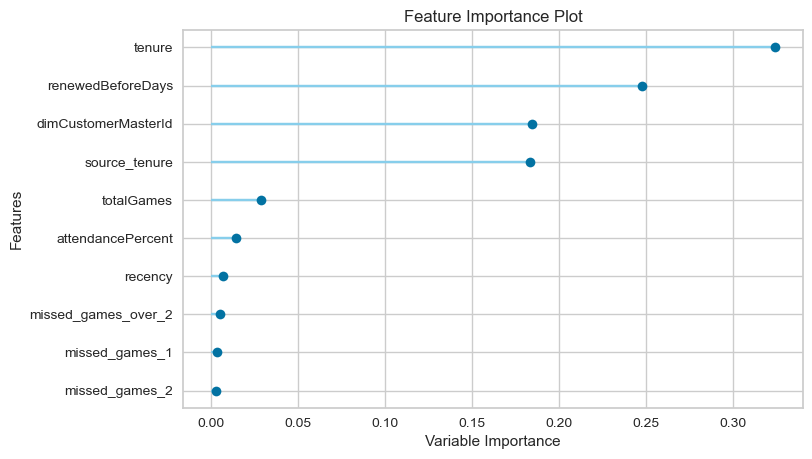

In [13]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?